In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Load the training data into feature matrix, class labels, and event ids:

In [3]:
import datetime
from proj1_helpers import *

DATA_TRAIN_PATH = 'data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [4]:
np.shape(tX)

(250000, 30)

In [5]:
def standardize(x, mean_x=None , std_x=None):
    """Standardize the original data set."""
    if mean_x==None:
        mean_x = np.mean(x)
        std_x = np.std(x)
        
    x = x - mean_x     
    x = x / std_x
    return x, mean_x, std_x


def build_model_data(y, x):
    """Form (y,tX) to get regression data in matrix form."""
    num_samples = len(y)
    tx = np.c_[np.ones(num_samples), x]
    return y, tx


# Data Exploration

## Correlations
here we study the different correlations because...

In [9]:
def correlation(a,b):
    #since we want to measure linear correlation between features and target we will use the pearson corrlation provided in numpy 
    return np.corrcoef(a,b)[0][1]

#### Correlation Feature/Target
lets first check which features are correlated or not with the target vector 'y'. Uncorrelated features have no use to predict 'y'

In [10]:
correlations=[]

for feature_index in range(len(tX[0])):
    #contains one feature of the dataset, namely one column of Tx
    feature=tX[:,feature_index]
    
    #first of all we have to filter out all the values equal to -999 (unknown values)
    indices=feature>-999
    feature=feature[indices]
    target=y[indices]
    
    corr = correlation(feature,target)
    
    correlations.append(corr)

#### Mutual correlation between features 
Having a look at the mutual correlation between features is important because if two of them are highly correlated we could just use one and simplify the model

In [11]:
correlation_matrix=[]
for index1 in range(len(tX[0])):
    correlations_row=[]#row of the correlation matrix
    for index2 in range(len(tX[0])):
        #contains one feature of the dataset, namely one column of Tx
        feature1=tX[:,index1]
        feature2=tX[:,index2]

        #first of all we have to filter out all the values equal to -999 (unknown values)
        indices=(feature1>-999) * (feature2>-999)
        feature1=feature1[indices]
        feature2=feature2[indices]
        
        corr = correlation(feature1,feature2)
        
        correlations_row.append(corr)
    correlation_matrix.append(correlations_row)

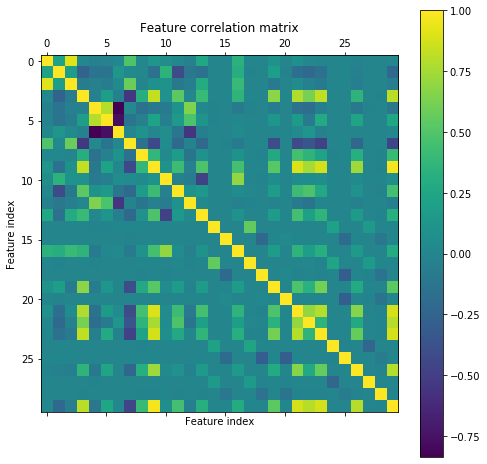

In [21]:
plt.figure(figsize=(8,8))
plt.matshow(correlation_matrix,fignum=1)
plt.colorbar()
plt.title("Feature correlation matrix")
plt.ylabel("Feature index")
plt.xlabel("Feature index")
plt.show()

We can see high values of correlation on the diagonal, these come from the auto-correlation of the features. The most interesting information that we see here is the others values that are close to one, these correspond to high correlations between two different features.

Note that the Feature correlation matrix is symetric 

## Correlations
In this section we will study the distributions (feature by feature) of the dataset. The result may help us to decide what to do with the missing values (-999) 

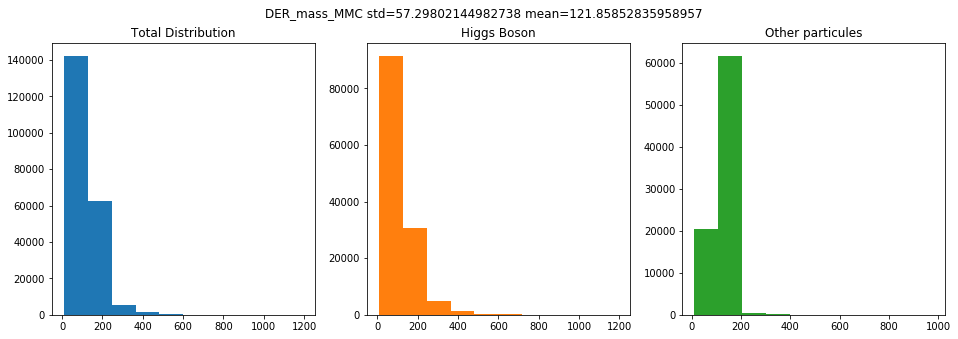

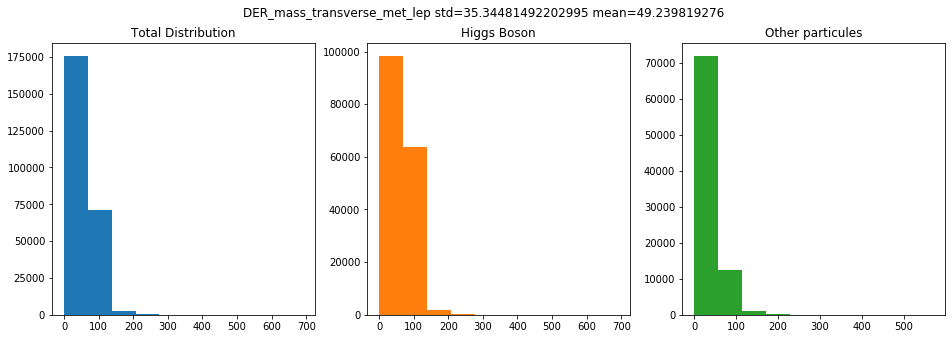

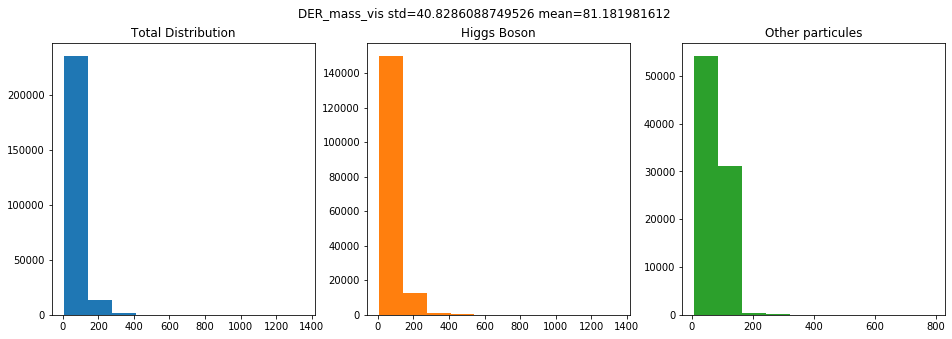

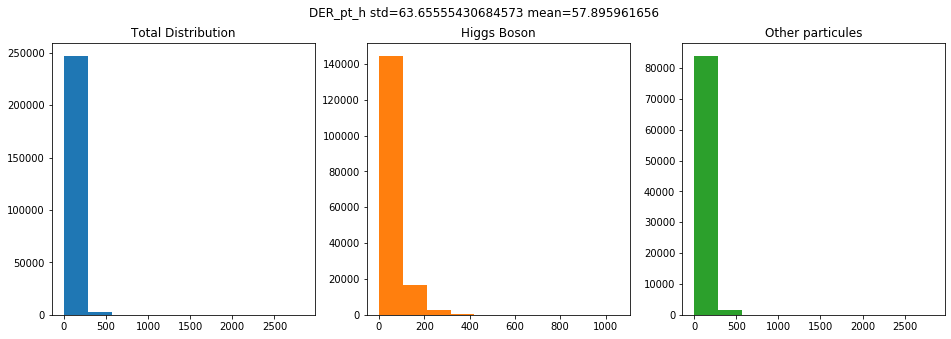

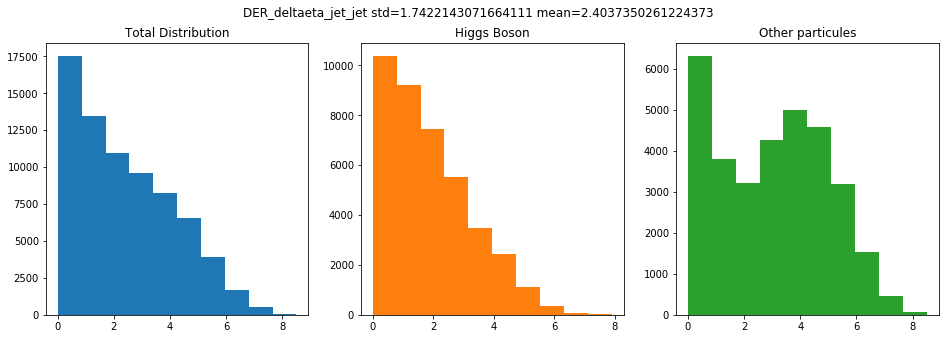

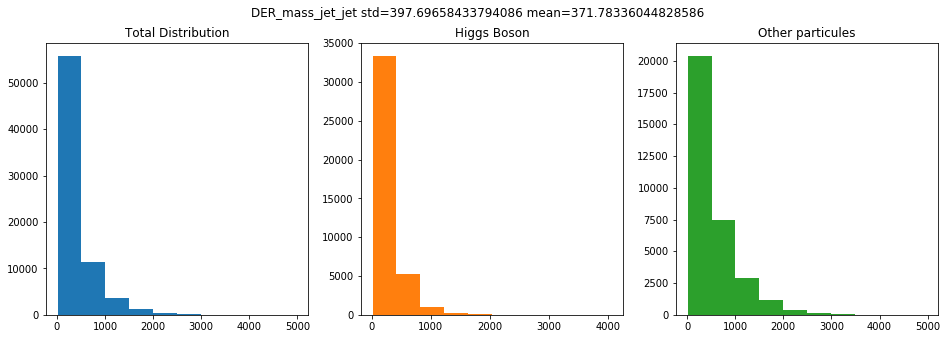

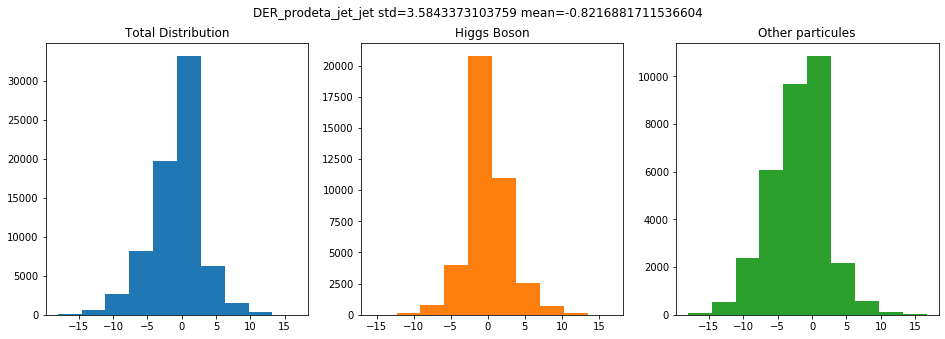

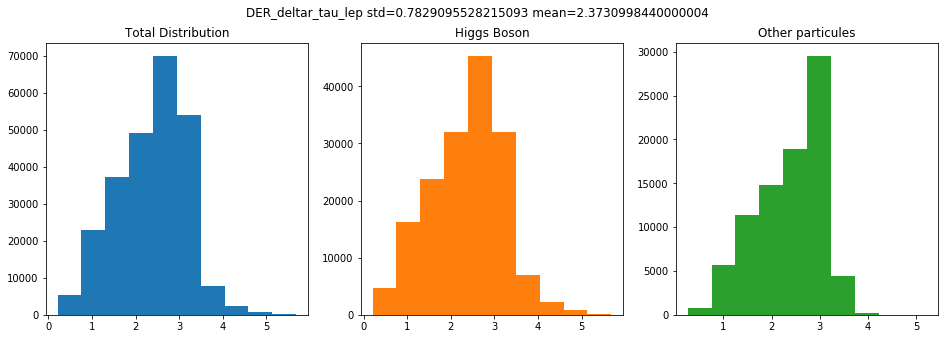

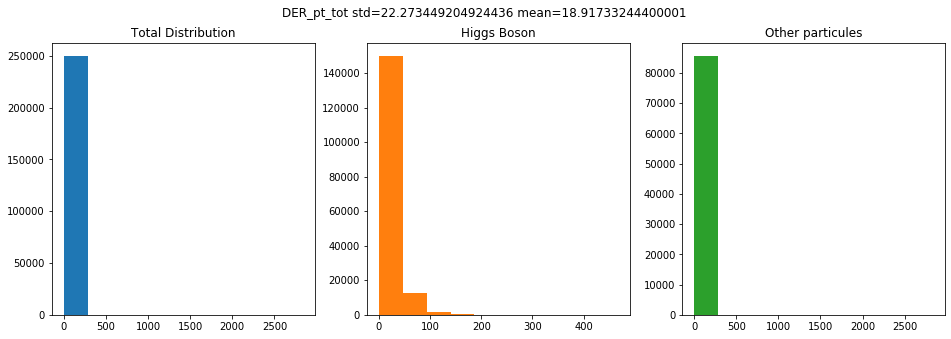

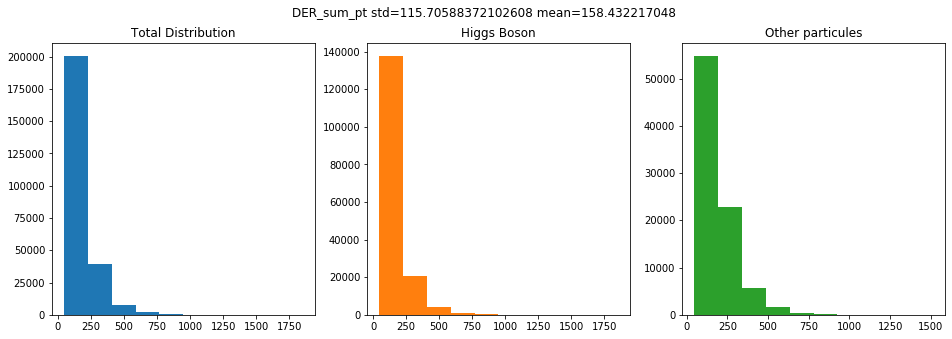

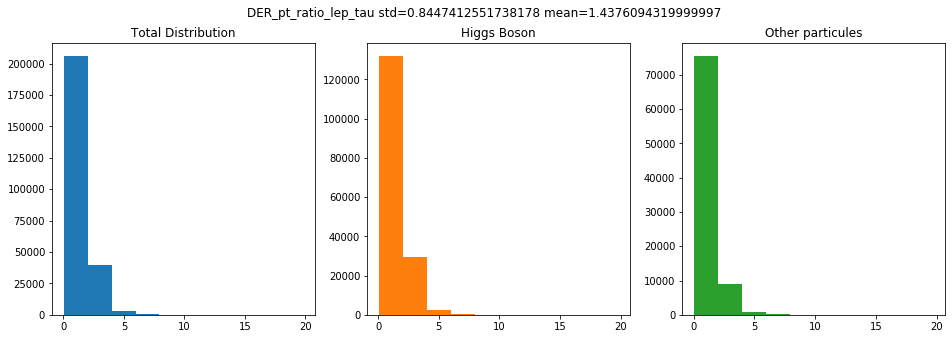

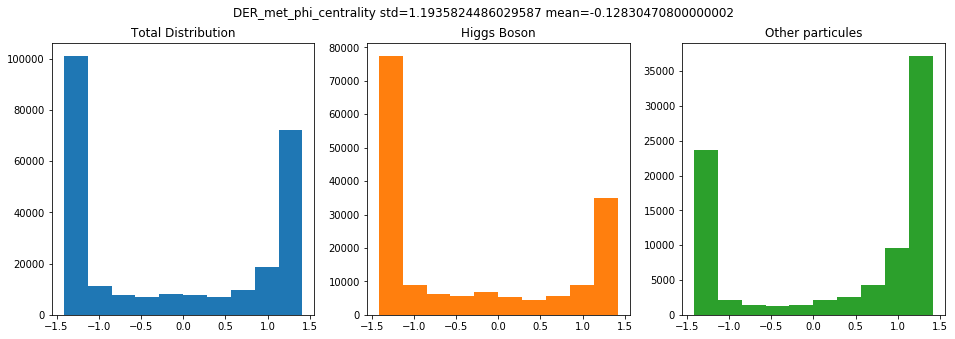

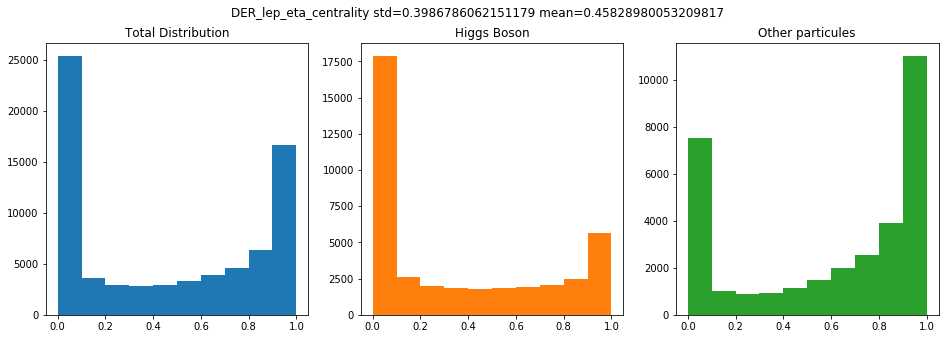

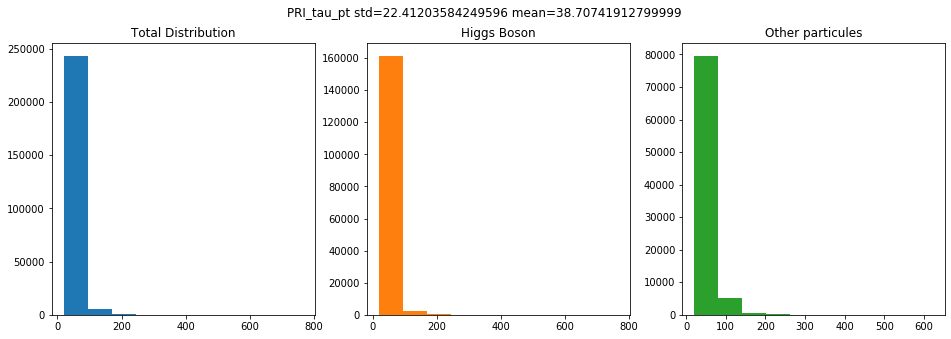

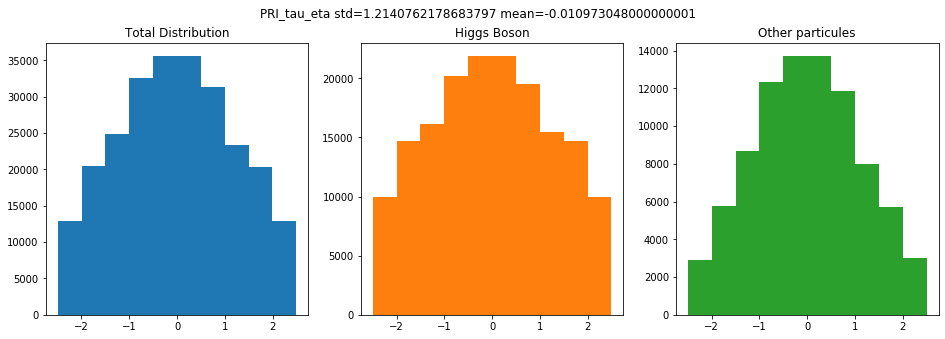

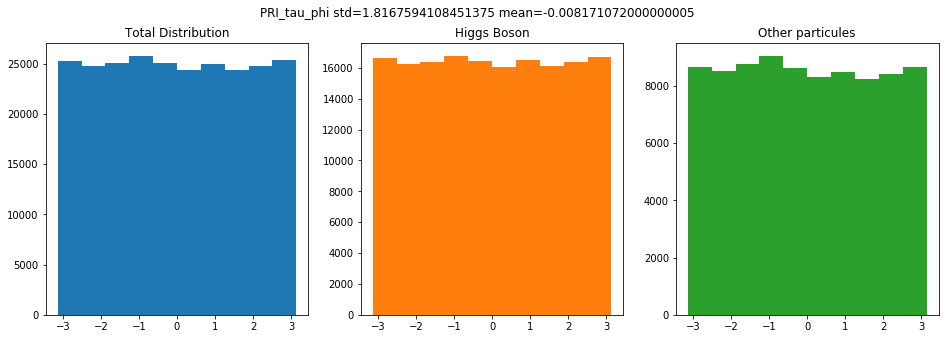

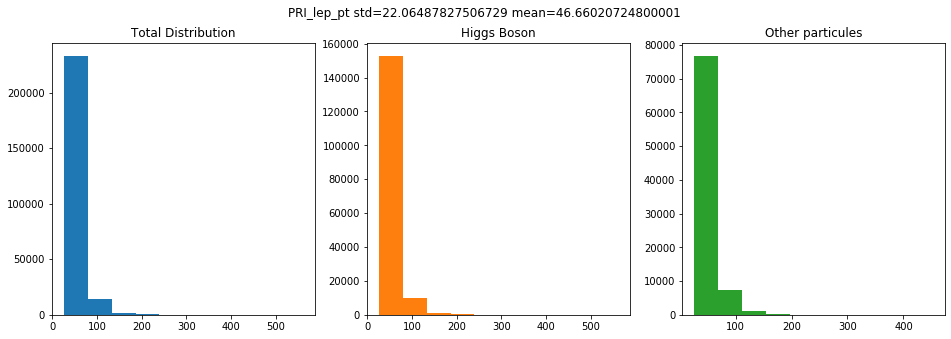

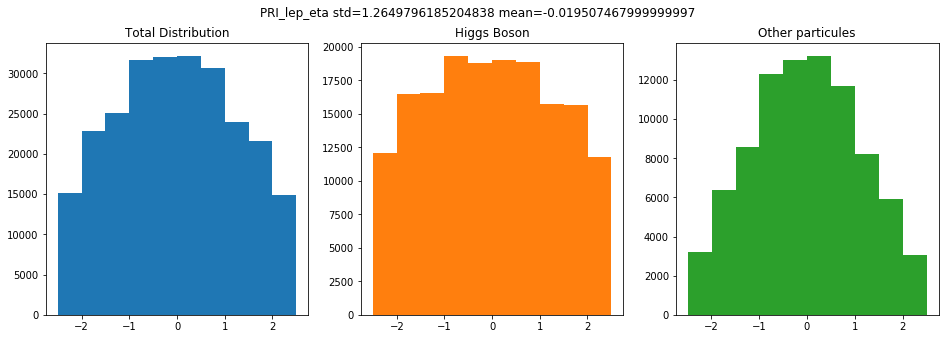

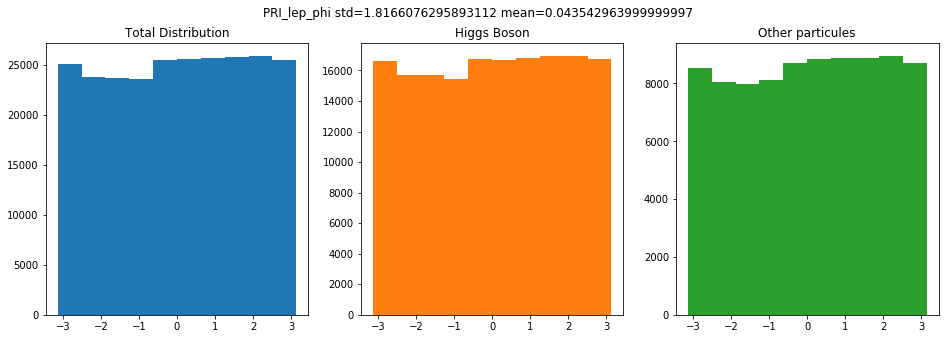

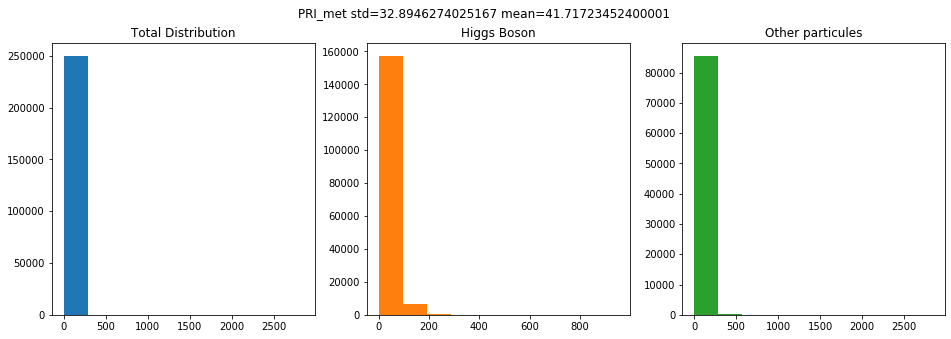

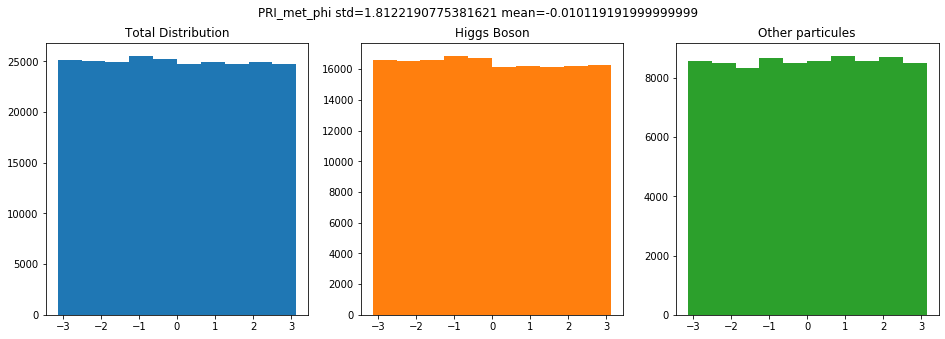

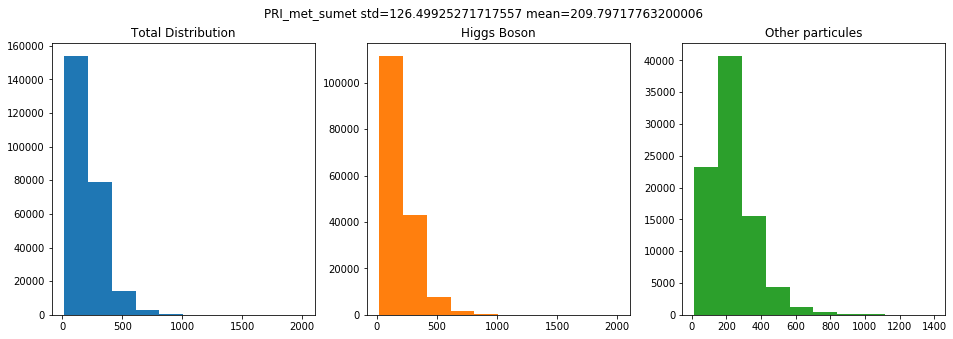

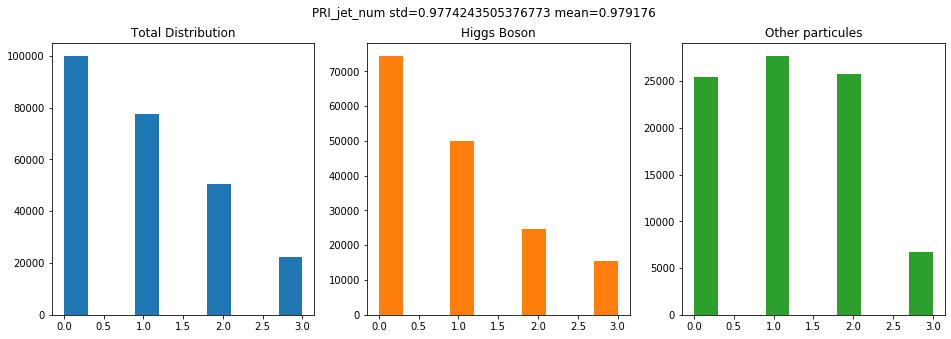

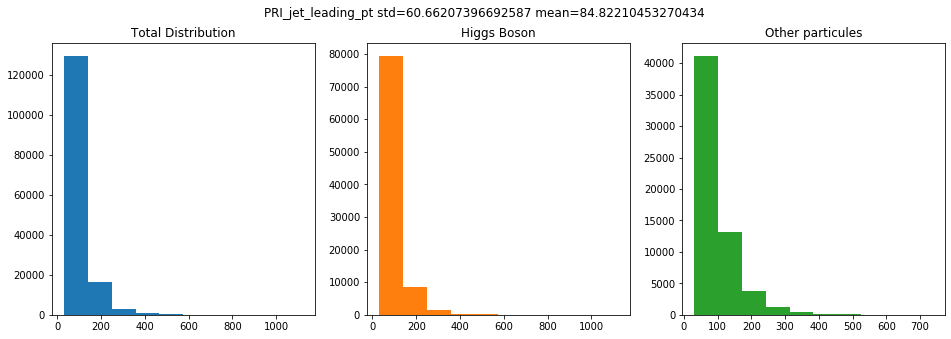

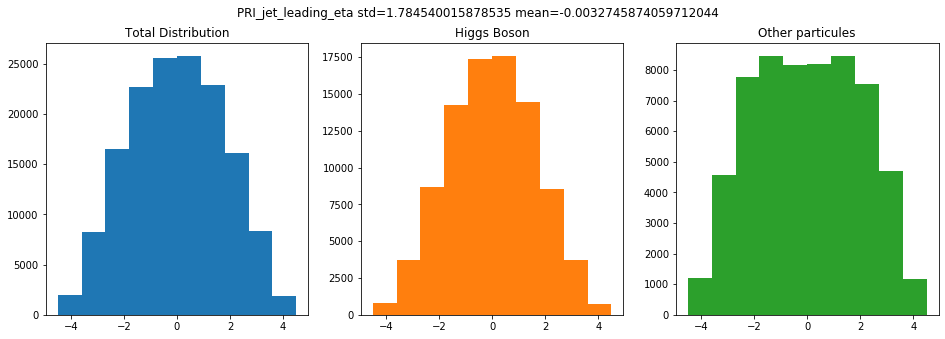

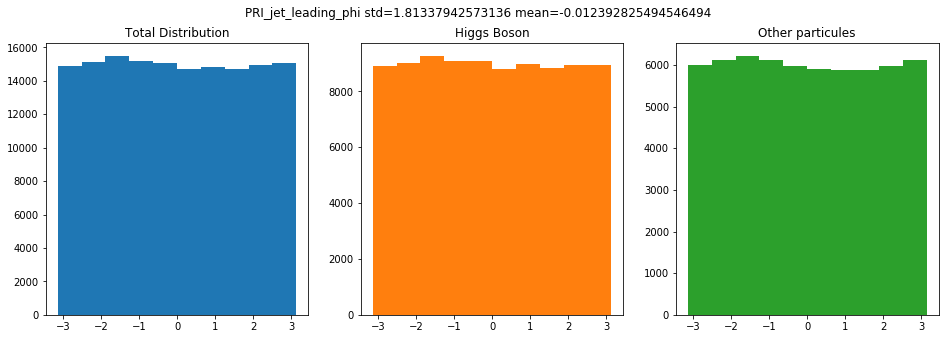

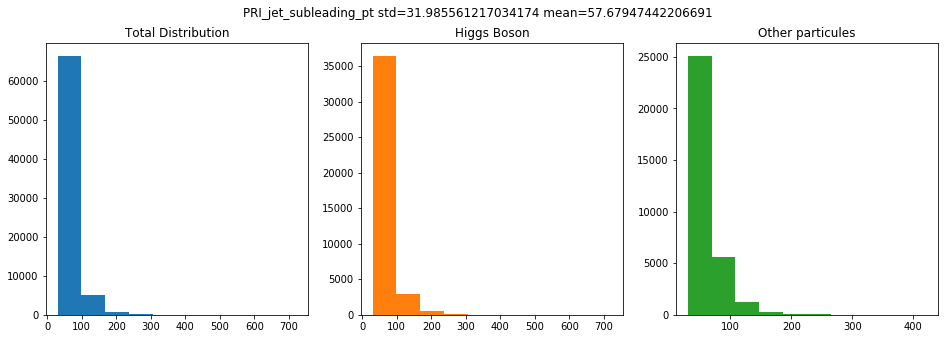

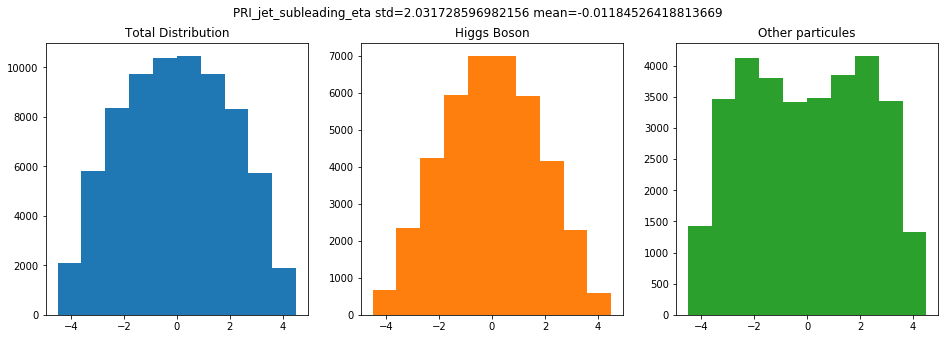

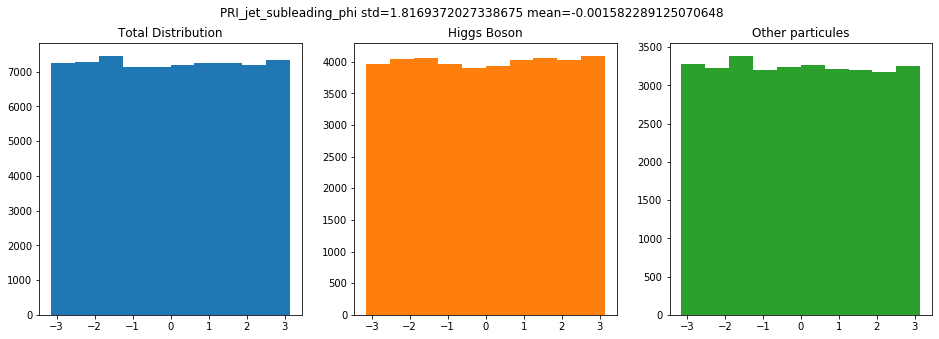

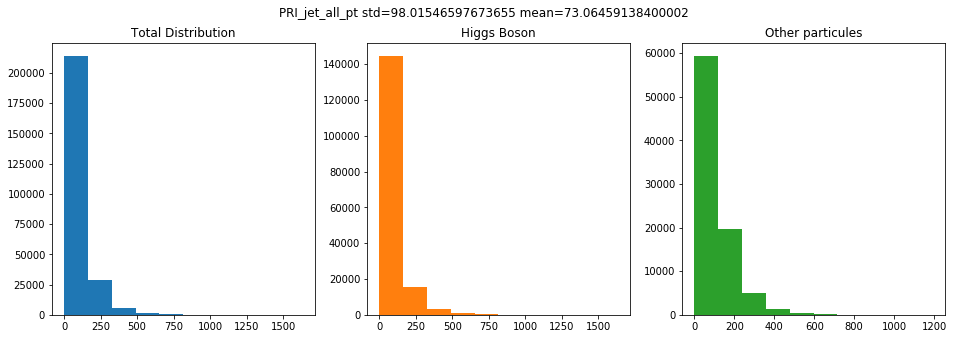

In [31]:
def plotHistogram(index, title,X,labels, filterMissingValues=True):
    extraCond = np.logical_or(np.full(labels.shape, not filterMissingValues, dtype=bool), (X[:,index]>-990))
    fig, axs = plt.subplots(1, 3,figsize=(16,5))
    axs[0].hist(X[extraCond,index])
    axs[0].set_title('Total Distribution')
    axs[1].hist(X[np.logical_and(labels==-1, extraCond),index], color='tab:orange')
    axs[1].set_title('Higgs Boson')
    axs[2].hist(X[np.logical_and(labels==1, extraCond),index], color='tab:green')
    axs[2].set_title('Other particules')
    fig.suptitle(title+ " std="+ str(np.std(X[extraCond,index])) + " mean="+ str(np.mean(X[extraCond,index])))

    #******************
    #plt.hist(X[:,index])
    plt.show()

names = ['DER_mass_MMC','DER_mass_transverse_met_lep','DER_mass_vis','DER_pt_h','DER_deltaeta_jet_jet','DER_mass_jet_jet','DER_prodeta_jet_jet','DER_deltar_tau_lep','DER_pt_tot','DER_sum_pt','DER_pt_ratio_lep_tau','DER_met_phi_centrality','DER_lep_eta_centrality','PRI_tau_pt','PRI_tau_eta','PRI_tau_phi','PRI_lep_pt','PRI_lep_eta','PRI_lep_phi','PRI_met','PRI_met_phi','PRI_met_sumet','PRI_jet_num','PRI_jet_leading_pt','PRI_jet_leading_eta','PRI_jet_leading_phi','PRI_jet_subleading_pt','PRI_jet_subleading_eta','PRI_jet_subleading_phi','PRI_jet_all_pt']
for index in range(tX.shape[1]):
    plotHistogram(index,names[index],tX,y)

# Data preprocessing

## Features extraction 
Reducing the number of features in the dataset could improve the precisiion of our future model (TODO : explai why) 

In [4]:
#indices of all data points that does'nt contain any values equal to -999 (unknown values)
indices=np.all(tX>-999,axis=1)
tX=tX[indices]
y=y[indices]

In [127]:
tX,tX_mean,tX_std=standardize(tX)
y,tX =build_model_data(y,tX)


# Do your thing crazy machine learning thing here :) ...

In [86]:
#Compute the loss using mse
def compute_loss(y, tx, w):
    e=y-tx.dot(w)
    n=len(y)
    return 1/(2*n)*e.dot(e)

#Compute the gradient of the loss function (mse)
def compute_gradient(y, tx, w):
    """Compute the gradient."""
    e=y-tx.dot(w)
    grd=tx.T.dot(e)
    return -(1/len(y))*grd 

In [87]:
#Gradient descent algorithm
def least_squares_GD(y, tx, initial_w,max_iters, gamma):

    w=initial_w
    
    for n_iter in range(max_iters):
        grd=compute_gradient(y,tx,w)
        w=w-gamma*grd
        
        loss=compute_loss(y,tx,w)
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    
    loss=compute_loss(y,tx,w)
    return w,loss
    

In [64]:
def compute_stoch_least_squares_gradient(y, tx, w):
    """Compute a stochastic gradient from just few examples n and their corresponding y_n labels."""   
    my=None
    mx=None
    for mmini_y,mini_x in batch_iter(y, tx, batch_size=1):
            my=mmini_y
            mx=mini_x
    
    return compute_gradient(my, mx, w)


def least_squares_SGD(y, tx, initial_w, batch_size, max_iters, gamma):
    "Gradient descent algorithm"
    w=initial_w
    for i in range(max_iters):
        print(i)
        grd=gamma*compute_stoch_least_squares_gradient(y,tx,w)
        w=w-grd
    loss=compute_loss(y,tx,w)
    
    return w, loss

In [129]:
max_iters = 500
gamma = 0.08
w_initial = np.zeros(len(tX[0]))

weights,loss=least_squares_GD(y,tX, w_initial,max_iters, gamma)

Gradient Descent(0/499): loss=0.46432477976815745, w0=-0.005080893795695452, w1=-0.001627853453127974
Gradient Descent(1/499): loss=0.4514018156604957, w0=-0.015607155269145077, w1=-0.005453818868881252
Gradient Descent(2/499): loss=0.4461721267208156, w0=-0.015414911569037034, w1=-0.004269585821195729
Gradient Descent(3/499): loss=0.4435862496672459, w0=-0.021322643132074312, w1=-0.005772148652084171
Gradient Descent(4/499): loss=0.4419445141622309, w0=-0.019737586194176624, w1=-0.0038382449919124755
Gradient Descent(5/499): loss=0.44066953863779956, w0=-0.02359233670605733, w1=-0.004355934608592177
Gradient Descent(6/499): loss=0.4395609403066671, w0=-0.02183523467576719, w1=-0.00232718133489184
Gradient Descent(7/499): loss=0.4385457740792175, w0=-0.024598833598555865, w1=-0.002354617005914637
Gradient Descent(8/499): loss=0.4375948086023829, w0=-0.02301727954220666, w1=-0.0004223100043880862
Gradient Descent(9/499): loss=0.43669431187204955, w0=-0.025094295988024574, w1=-0.00016225

Gradient Descent(97/499): loss=0.40797654637286646, w0=-0.02360391934331698, w1=0.06313448845972944
Gradient Descent(98/499): loss=0.4078590862715419, w0=-0.023653332056391384, w1=0.06353551541050308
Gradient Descent(99/499): loss=0.40774333497534854, w0=-0.02370404033428211, w1=0.06393254094171591
Gradient Descent(100/499): loss=0.4076292530870533, w0=-0.023755787547265764, w1=0.06432574136124455
Gradient Descent(101/499): loss=0.4075168023776932, w0=-0.02380875023149733, w1=0.06471509531178891
Gradient Descent(102/499): loss=0.40740594574858446, w0=-0.023862719639062297, w1=0.06510075494027916
Gradient Descent(103/499): loss=0.407296647194604, w0=-0.023917831329928446, w1=0.06548271507480244
Gradient Descent(104/499): loss=0.40718887176869867, w0=-0.023973914778654997, w1=0.06586110818413045
Gradient Descent(105/499): loss=0.40708258554758364, w0=-0.024031073152830262, w1=0.06623594148965517
Gradient Descent(106/499): loss=0.4069777555985855, w0=-0.02408916646822208, w1=0.06660733136

Gradient Descent(186/499): loss=0.4015369746719343, w0=-0.03035854116478495, w1=0.08900544614483195
Gradient Descent(187/499): loss=0.40149242960642556, w0=-0.030443604572763263, w1=0.08922704026675833
Gradient Descent(188/499): loss=0.40144826511071685, w0=-0.030528615336235333, w1=0.0894477264708398
Gradient Descent(189/499): loss=0.4014044767349929, w0=-0.030613568634317318, w1=0.08966751708401373
Gradient Descent(190/499): loss=0.4013610601080628, w0=-0.030698459739455373, w1=0.08988642420397332
Gradient Descent(191/499): loss=0.40131801093535296, w0=-0.030783284045049108, w1=0.09010445969050276
Gradient Descent(192/499): loss=0.40127532499696306, w0=-0.03086803703714163, w1=0.09032163518209506
Gradient Descent(193/499): loss=0.40123299814577934, w0=-0.03095271431603271, w1=0.09053796208985118
Gradient Descent(194/499): loss=0.4011910263056482, w0=-0.031037311573449404, w1=0.09075345161145451
Gradient Descent(195/499): loss=0.4011494054696033, w0=-0.03112182460939445, w1=0.09096811

Gradient Descent(283/499): loss=0.39851727794570163, w0=-0.03793031069933598, w1=0.10750342582940184
Gradient Descent(284/499): loss=0.3984961683031857, w0=-0.037998732370761665, w1=0.10767129705456906
Gradient Descent(285/499): loss=0.3984752069566897, w0=-0.03806693745756336, w1=0.10783881831045694
Gradient Descent(286/499): loss=0.3984543926410312, w0=-0.03813492600417661, w1=0.10800599177876229
Gradient Descent(287/499): loss=0.39843372410358274, w0=-0.038202698070797056, w1=0.10817281960761771
Gradient Descent(288/499): loss=0.3984132001041097, w0=-0.038270253733024215, w1=0.10833930391225312
Gradient Descent(289/499): loss=0.3983928194146125, w0=-0.038337593081512654, w1=0.10850544677564355
Gradient Descent(290/499): loss=0.39837258081917093, w0=-0.03840471622162876, w1=0.10867125024914438
Gradient Descent(291/499): loss=0.3983524831137915, w0=-0.038471623273114514, w1=0.10883671635311348
Gradient Descent(292/499): loss=0.39833252510625816, w0=-0.03853831436975684, w1=0.109001847

Gradient Descent(377/499): loss=0.39704288387262715, w0=-0.043454081708283444, w1=0.1219714273515014
Gradient Descent(378/499): loss=0.39703149553105405, w0=-0.04350364887988983, w1=0.1221128994758702
Gradient Descent(379/499): loss=0.39702017612494406, w0=-0.04355303981949134, w1=0.12225413936369363
Gradient Descent(380/499): loss=0.39700892511862707, w0=-0.04360225511175564, w1=0.12239514774194306
Gradient Descent(381/499): loss=0.3969977419810451, w0=-0.04365129534149212, w1=0.12253592533207155
Gradient Descent(382/499): loss=0.3969866261857083, w0=-0.04370016109359816, w1=0.12267647285011135
Gradient Descent(383/499): loss=0.39697557721065346, w0=-0.04374885295300657, w1=0.12281679100676932
Gradient Descent(384/499): loss=0.3969645945384012, w0=-0.04379737150463426, w1=0.12295688050752052
Gradient Descent(385/499): loss=0.3969536776559147, w0=-0.043845717333332056, w1=0.1230967420526998
Gradient Descent(386/499): loss=0.3969428260545582, w0=-0.04389389102383569, w1=0.12323637633759

Gradient Descent(464/499): loss=0.39626208387057366, w0=-0.04716794432079676, w1=0.13347826623344822
Gradient Descent(465/499): loss=0.3962550963785602, w0=-0.04720429737099551, w1=0.13360182807811466
Gradient Descent(466/499): loss=0.3962481447471623, w0=-0.04724052192359828, w1=0.1337252073345139
Gradient Descent(467/499): loss=0.3962412287189133, w0=-0.047276618464797276, w1=0.1338484044688996
Gradient Descent(468/499): loss=0.39623434803845325, w0=-0.04731258747908085, w1=0.13397141994595288
Gradient Descent(469/499): loss=0.39622750245250965, w0=-0.047348429449231344, w1=0.1340942542287979
Gradient Descent(470/499): loss=0.39622069170988006, w0=-0.04738414485632304, w1=0.134216907779017
Gradient Descent(471/499): loss=0.39621391556141333, w0=-0.047419734179720445, w1=0.1343393810566656
Gradient Descent(472/499): loss=0.3962071737599925, w0=-0.0474551978970766, w1=0.13446167452028673
Gradient Descent(473/499): loss=0.3962004660605163, w0=-0.04749053648433177, w1=0.13458378862692524

# Model evaluation

In [130]:
def accuracy(y,tX,weights):
    pred=predict_labels(weights, tX)
    return np.sum(pred==y)/len(y)

In [132]:
print('accuracy=',accuracy(y,tX,weights))

accuracy= 0.7020289514637226


# Generate predictions and save ouput in csv format for submission:

In [117]:
DATA_TEST_PATH = 'data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
OUTPUT_PATH = 'data/submission.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)